### start

In [4]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.workflow_orchestrator as wo
import sage_wallet_insights.model_evaluation as sime

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    wm, wo,
    sime,
    ucv, s3u,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        'sage_wallet_insights',
        'sage_wallet_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[31/Jul/25 15:17:47] INFO [utils.export_code:1659] Consolidation complete. All files are saved in temp/sagemaker_code.py
[31/Jul/25 15:17:47] MILESTONE [3934705018.<module>:127] Good morning, let's get to work


# Model Training

### Initiate orchestrator

In [5]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)

### Load, preprocess, and upload all data

#### load data

In [6]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch.load_all_training_data(date_suffixes)

[31/Jul/25 15:18:31] MILESTONE [workflow_orchestrator.load_all_training_data:121] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[31/Jul/25 15:18:32] INFO [workflow_orchestrator.load_all_training_data:137] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.


##### inspect features

In [ ]:
# Create combined NaN count and describe statistics
first_key = next(iter(workflow_orch.training_data))
nan_counts = workflow_orch.training_data[first_key]['x_train'].isna().sum()
describe_stats = workflow_orch.training_data[first_key]['x_train'].describe().T

# Combine into single DataFrame
combined_stats = pd.concat([
    nan_counts.rename('nan_count'),
    describe_stats
], axis=1).sort_index()

u.display_full(combined_stats.sort_index())

#### preprocess all data

In [7]:
workflow_orch.preprocess_all_training_data()

[31/Jul/25 15:18:35] INFO [workflow_orchestrator.preprocess_all_training_data:168] Preprocessing 4 date periods...
[31/Jul/25 15:18:35] INFO [wallet_preprocessor.preprocess_training_data:77] Starting preprocessing for SageMaker XGBoost compatibility...
[31/Jul/25 15:18:35] INFO [wallet_preprocessor._handle_missing_values:235] Filled NaN values in 100 columns for x_train.
[31/Jul/25 15:18:35] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to y_train: 5,864 positive (29.7%), 13,874 negative (70.3%)
[31/Jul/25 15:18:35] INFO [wallet_preprocessor._combine_x_y_data:385] Merged y df with target var cw_crypto_net_gain/crypto_inflows/winsorized with X data.
[31/Jul/25 15:18:36] INFO [wallet_preprocessor._save_preprocessed_df:431] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_920_eval_models_nginv_040/231008/train.csv
[31/Jul/25 15:18:36] INFO [wallet_preprocessor.preprocess_training_data:119] Preprocessed train: 19

#### upload all data

In [8]:
# Upload and retrieve URIs
workflow_orch.upload_all_training_data(overwrite_existing=True)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

[31/Jul/25 15:19:33] MILESTONE [workflow_orchestrator._confirm_upload:744] <PROD> Ready to upload 372871 total rows (630.3 MB) of preprocessed training data across 4 date folders.
[31/Jul/25 15:19:33] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[31/Jul/25 15:19:33] INFO [workflow_orchestrator._confirm_upload:764] Target: s3://wallet-training-data/training-data-preprocessed/dda-920-nginv-040/[DATE]/
[31/Jul/25 15:19:38] INFO [workflow_orchestrator.upload_all_training_data:215] Beginning approved upload...
[31/Jul/25 15:19:38] INFO [workflow_orchestrator.upload_all_training_data:220] Uploading data for 4 date periods with 4 threads...
[31/Jul/25 15:23:23] INFO [workflow_orchestrator._upload_csv_files:812] Uploaded train to s3://wallet-training-data/training-data-preprocessed/dda-920-nginv-040/231008/train.csv
[31/Jul/25 15:23:50] INFO [workflow_orchestrator._upload_csv_files:812] Uploaded train to s3://wallet-training-data/training-data-p

### Train all models

In [9]:
workflow_orch.load_all_training_data(date_suffixes)
modeling_results = workflow_orch.train_all_models()

[31/Jul/25 15:27:55] MILESTONE [workflow_orchestrator.load_all_training_data:121] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[31/Jul/25 15:27:56] INFO [workflow_orchestrator.load_all_training_data:137] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.
[31/Jul/25 15:27:57] INFO [workflow_orchestrator.train_all_models:331] Training models for 4 date periods with 4 threads...
[31/Jul/25 15:27:57] INFO [wallet_modeler.train_model:124] Starting SageMaker training sequence...
[31/Jul/25 15:27:57] INFO [wallet_modeler.train_model:124] Starting SageMaker training sequence...
[31/Jul/25 15:27:57] INFO [wallet_modeler.train_model:124] Starting SageMaker training sequence...
[31/Jul/25 15:27:57] INFO [wallet_modeler.train_model:124] Starting SageMaker training sequence...
[31/Jul/25 15:27:57] INFO [wallet_modeler._configure_estimator:487] Model type: classification, Objective: binary:logistic
[31/Jul/25 15:27:57] IN

2025-07-31 22:27:59 Starting - Starting the training job2025-07-31 22:27:59 Starting - Starting the training job..2025-07-31 22:28:04 Starting - Starting the training job2025-07-31 22:28:00 Starting - Starting the training job..........
2025-07-31 22:28:14 Starting - Preparing the instances for training
2025-07-31 22:28:13 Starting - Preparing the instances for training..
2025-07-31 22:28:15 Starting - Preparing the instances for training
2025-07-31 22:28:18 Starting - Preparing the instances for training..........

2025-07-31 22:28:36 Downloading - Downloading input data2025-07-31 22:28:39 Downloading - Downloading input data..
2025-07-31 22:28:42 Downloading - Downloading input data
2025-07-31 22:28:45 Downloading - Downloading input data..........

2025-07-31 22:29:27 Downloading - Downloading the training image2025-07-31 22:29:24 Downloading - Downloading the training image..
2025-07-31 22:29:31 Downloading - Downloading the training image
2025-07-31 22:29:28 Downloading - Download

[31/Jul/25 15:31:21] INFO [wallet_modeler._upload_training_artifacts:677] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-231107-20250731-152757/training_metadata.json
[31/Jul/25 15:31:21] INFO [wallet_modeler.train_model:164] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-231107-20250731-152757/output/model.tar.gz
[31/Jul/25 15:31:21] INFO [wallet_modeler._upload_training_artifacts:677] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-231008-20250731-152757/training_metadata.json
[31/Jul/25 15:31:21] INFO [wallet_modeler.train_model:164] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-231008-20250731-152757/output/model.tar.gz
[31/Jul/25 15:31:21] INFO [workflow_orchestrator._train_single_mod

[18]#011train-aucpr:0.87154#011validation-aucpr:0.84451
[19]#011train-aucpr:0.87311#011validation-aucpr:0.84554
[20]#011train-aucpr:0.87635#011validation-aucpr:0.85005
[21]#011train-aucpr:0.87843#011validation-aucpr:0.85128
[22]#011train-aucpr:0.88011#011validation-aucpr:0.85124
[23]#011train-aucpr:0.88400#011validation-aucpr:0.85527
[24]#011train-aucpr:0.88532#011validation-aucpr:0.85533
[25]#011train-aucpr:0.88781#011validation-aucpr:0.85728
[26]#011train-aucpr:0.88917#011validation-aucpr:0.85792
[27]#011train-aucpr:0.89097#011validation-aucpr:0.85690
[28]#011train-aucpr:0.89188#011validation-aucpr:0.85730
[29]#011train-aucpr:0.89251#011validation-aucpr:0.85774
[30]#011train-aucpr:0.89358#011validation-aucpr:0.85881
[31]#011train-aucpr:0.89512#011validation-aucpr:0.85914
[32]#011train-aucpr:0.89655#011validation-aucpr:0.86107
[33]#011train-aucpr:0.89727#011validation-aucpr:0.86055
[34]#011train-aucpr:0.89885#011validation-aucpr:0.86144
[35]#011train-aucpr:0.90028#011validation-aucpr:

[31/Jul/25 15:32:36] INFO [wallet_modeler._upload_training_artifacts:677] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-250301-20250731-152757/training_metadata.json
[31/Jul/25 15:32:36] INFO [wallet_modeler.train_model:164] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-250301-20250731-152757/output/model.tar.gz
[31/Jul/25 15:32:36] INFO [workflow_orchestrator._train_single_model:871] Successfully completed training for 250301



2025-07-31 22:32:11 Completed - Training job completed
Training seconds: 215
Billable seconds: 215


[31/Jul/25 15:32:54] INFO [wallet_modeler._upload_training_artifacts:677] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-240306-20250731-152757/training_metadata.json
[31/Jul/25 15:32:54] INFO [wallet_modeler.train_model:164] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-240306-20250731-152757/output/model.tar.gz
[31/Jul/25 15:32:54] INFO [workflow_orchestrator._train_single_model:871] Successfully completed training for 240306
[31/Jul/25 15:32:54] INFO [workflow_orchestrator.train_all_models:344] All 4 models trained successfully.


### Predict with all models

In [10]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

[31/Jul/25 15:32:54] MILESTONE [workflow_orchestrator.load_all_training_data:121] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[31/Jul/25 15:32:55] INFO [workflow_orchestrator.load_all_training_data:137] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.


In [11]:
result = workflow_orch.predict_with_all_models()

[31/Jul/25 15:32:57] MILESTONE [workflow_orchestrator.predict_with_all_models:378] Generating predictions for 4 date periods with 4 threads...
[31/Jul/25 15:32:57] INFO [workflow_orchestrator.predict_with_all_models:380] Dataset types: ['test', 'val']
[31/Jul/25 15:32:57] INFO [wallet_modeler.load_existing_model:240] Loaded most recent model (timestamp: 20250731-152757): s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-231008-20250731-152757/output/model.tar.gz
[31/Jul/25 15:32:57] INFO [wallet_modeler.load_existing_model:240] Loaded most recent model (timestamp: 20250731-152757): s3://wallet-training-data/sagemaker-models/dda-920-nginv-040/wallet-xgb-dda-920-nginv-040-240306-20250731-152757/output/model.tar.gz
[31/Jul/25 15:32:57] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[31/Jul/25 15:32:57] INFO [wallet_modeler.load_existing_model:240] Loaded most recent model (timestamp: 20250731-152757): s3://wallet-training

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................!

[31/Jul/25 15:37:58] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/250301/wallet-scoring-250301-153301-test/test.csv.out



.

[31/Jul/25 15:37:58] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/250301/test.csv.out.


......................!

[31/Jul/25 15:38:15] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/231107/wallet-scoring-231107-153258-test/test.csv.out



.

[31/Jul/25 15:38:15] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/231107/test.csv.out.


..........!

[31/Jul/25 15:38:24] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/231107/wallet-scoring-231107-153303-val/val.csv.out


[31/Jul/25 15:38:25] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/231107/val.csv.out.
[31/Jul/25 15:38:25] MILESTONE [workflow_orchestrator._predict_with_single_model:933] Successfully completed predictions for 231107: ['test', 'val']


.......!

[31/Jul/25 15:38:33] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/231008/wallet-scoring-231008-153258-test/test.csv.out



.

[31/Jul/25 15:38:33] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/231008/test.csv.out.


!

[31/Jul/25 15:38:33] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/240306/wallet-scoring-240306-153303-test/test.csv.out


[31/Jul/25 15:38:34] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/240306/test.csv.out.


..!

[31/Jul/25 15:38:38] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/240306/wallet-scoring-240306-153258-val/val.csv.out


[31/Jul/25 15:38:38] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/240306/val.csv.out.
[31/Jul/25 15:38:38] MILESTONE [workflow_orchestrator._predict_with_single_model:933] Successfully completed predictions for 240306: ['test', 'val']


!

[31/Jul/25 15:38:40] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/231008/wallet-scoring-231008-153258-val/val.csv.out


[31/Jul/25 15:38:41] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/231008/val.csv.out.
[31/Jul/25 15:38:41] MILESTONE [workflow_orchestrator._predict_with_single_model:933] Successfully completed predictions for 231008: ['test', 'val']


!

[31/Jul/25 15:38:42] INFO [wallet_modeler._execute_batch_transform:792] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-920-nginv-040/250301/wallet-scoring-250301-153259-val/val.csv.out


[31/Jul/25 15:38:42] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_920_eval_models_nginv_040/250301/val.csv.out.
[31/Jul/25 15:38:42] MILESTONE [workflow_orchestrator._predict_with_single_model:933] Successfully completed predictions for 250301: ['test', 'val']
[31/Jul/25 15:38:42] MILESTONE [workflow_orchestrator.predict_with_all_models:399] All 4 models generated predictions successfully.


### Evaluate all models

In [13]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)

evaluators = workflow_orch.evaluate_all_models()


[31/Jul/25 15:39:24] MILESTONE [workflow_orchestrator.load_all_training_data:121] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[31/Jul/25 15:39:24] INFO [workflow_orchestrator.load_all_training_data:137] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.
[31/Jul/25 15:39:24] MILESTONE [workflow_orchestrator.evaluate_all_models:416] Evaluating 4 models with 4 threads...
[31/Jul/25 15:39:24] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to train: 5,864 positive (29.7%), 13,874 negative (70.3%)
[31/Jul/25 15:39:24] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to test: 1,125 positive (30.4%), 2,577 negative (69.6%)
[31/Jul/25 15:39:24] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to val: 12,020 positive (60.3%), 7,927 negative (39.7%)
[31/Jul/25 15:39:24] INFO [wallet_preprocessor.preproce

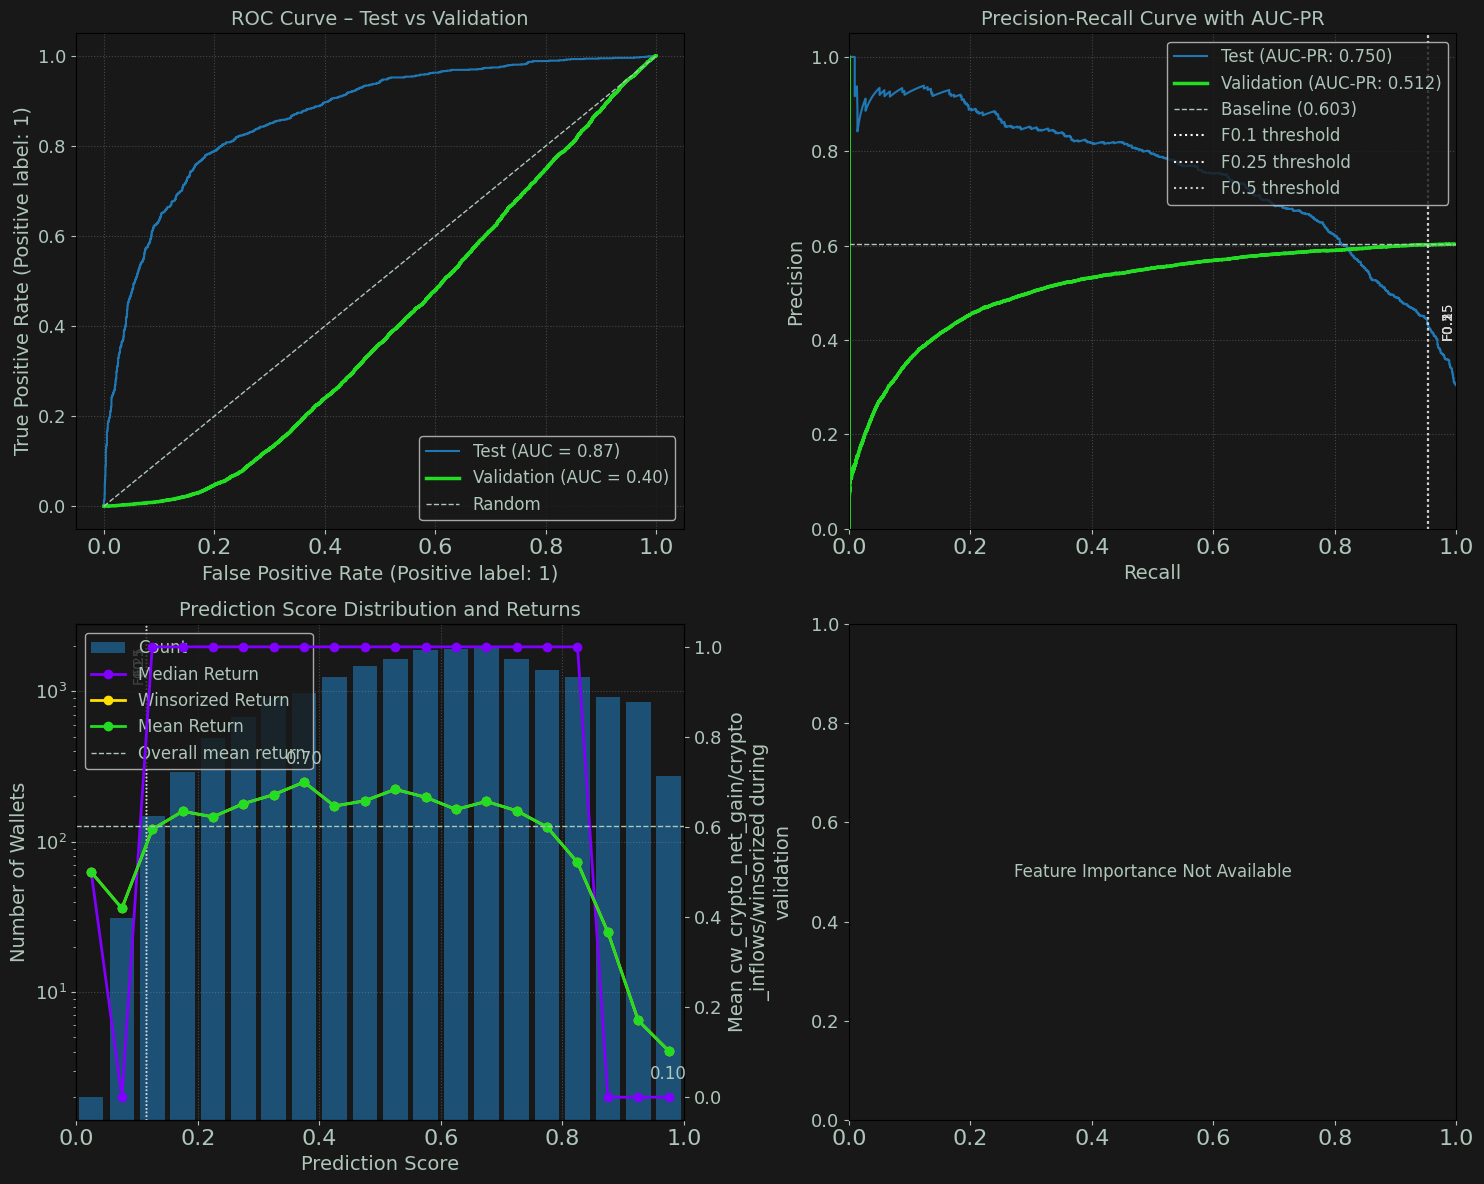

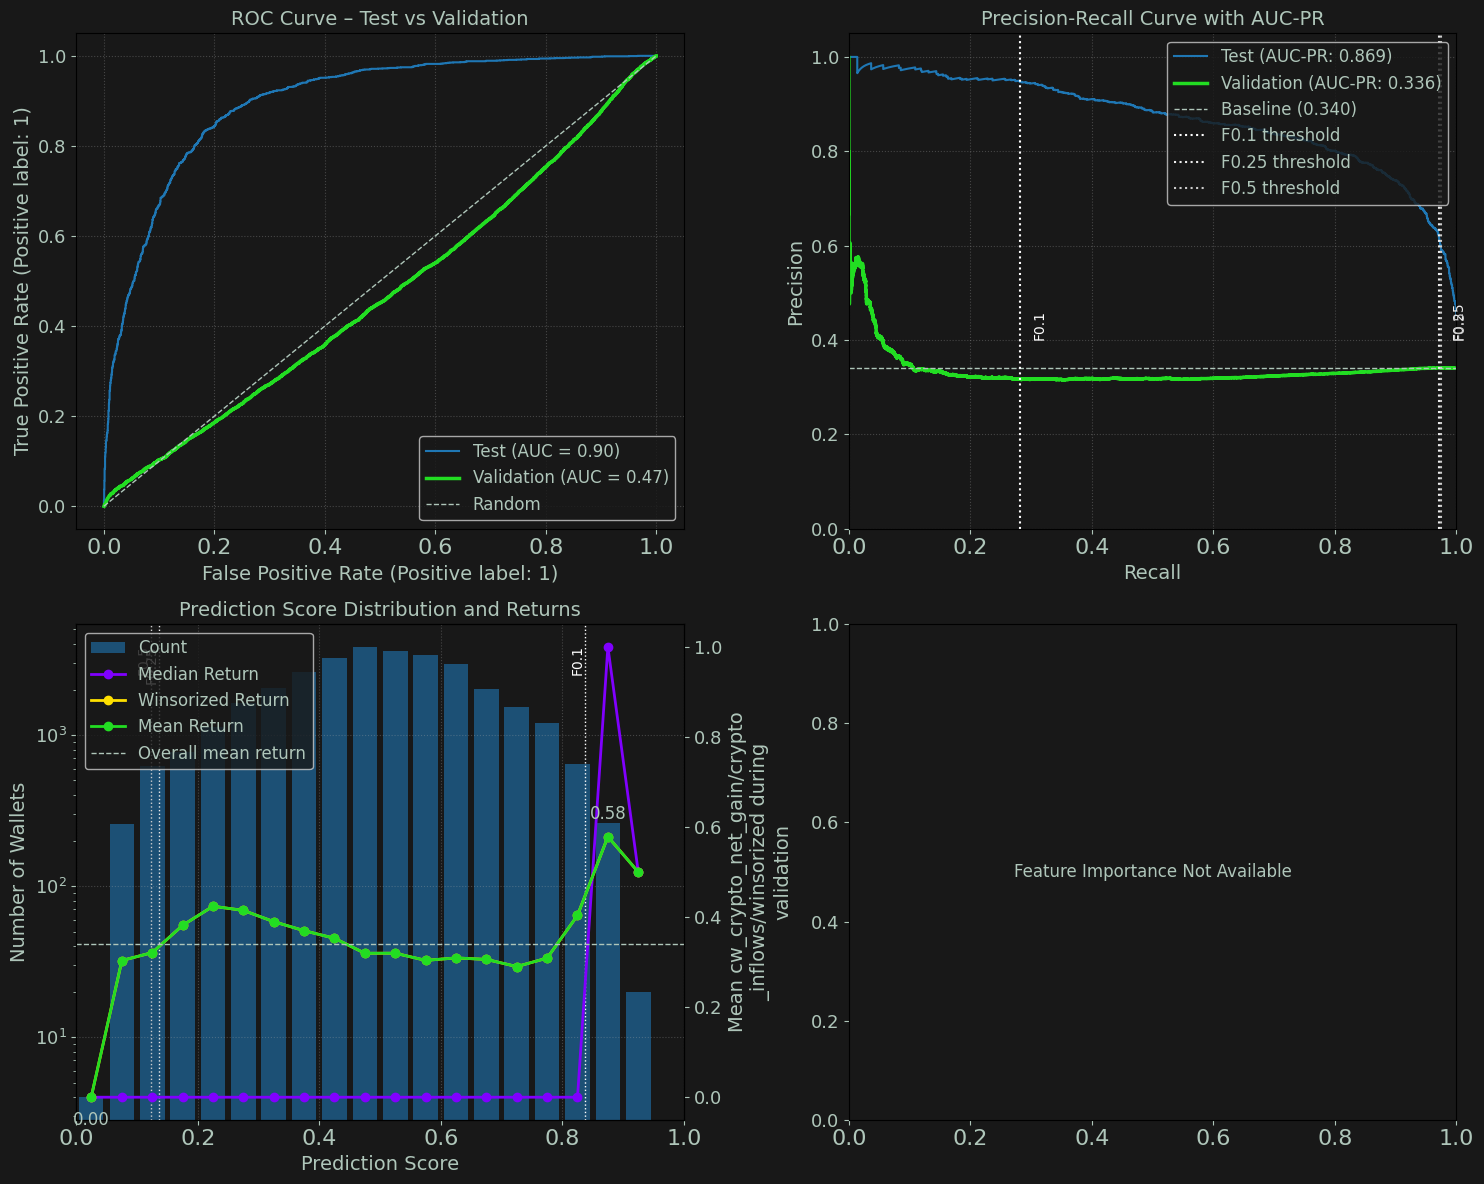

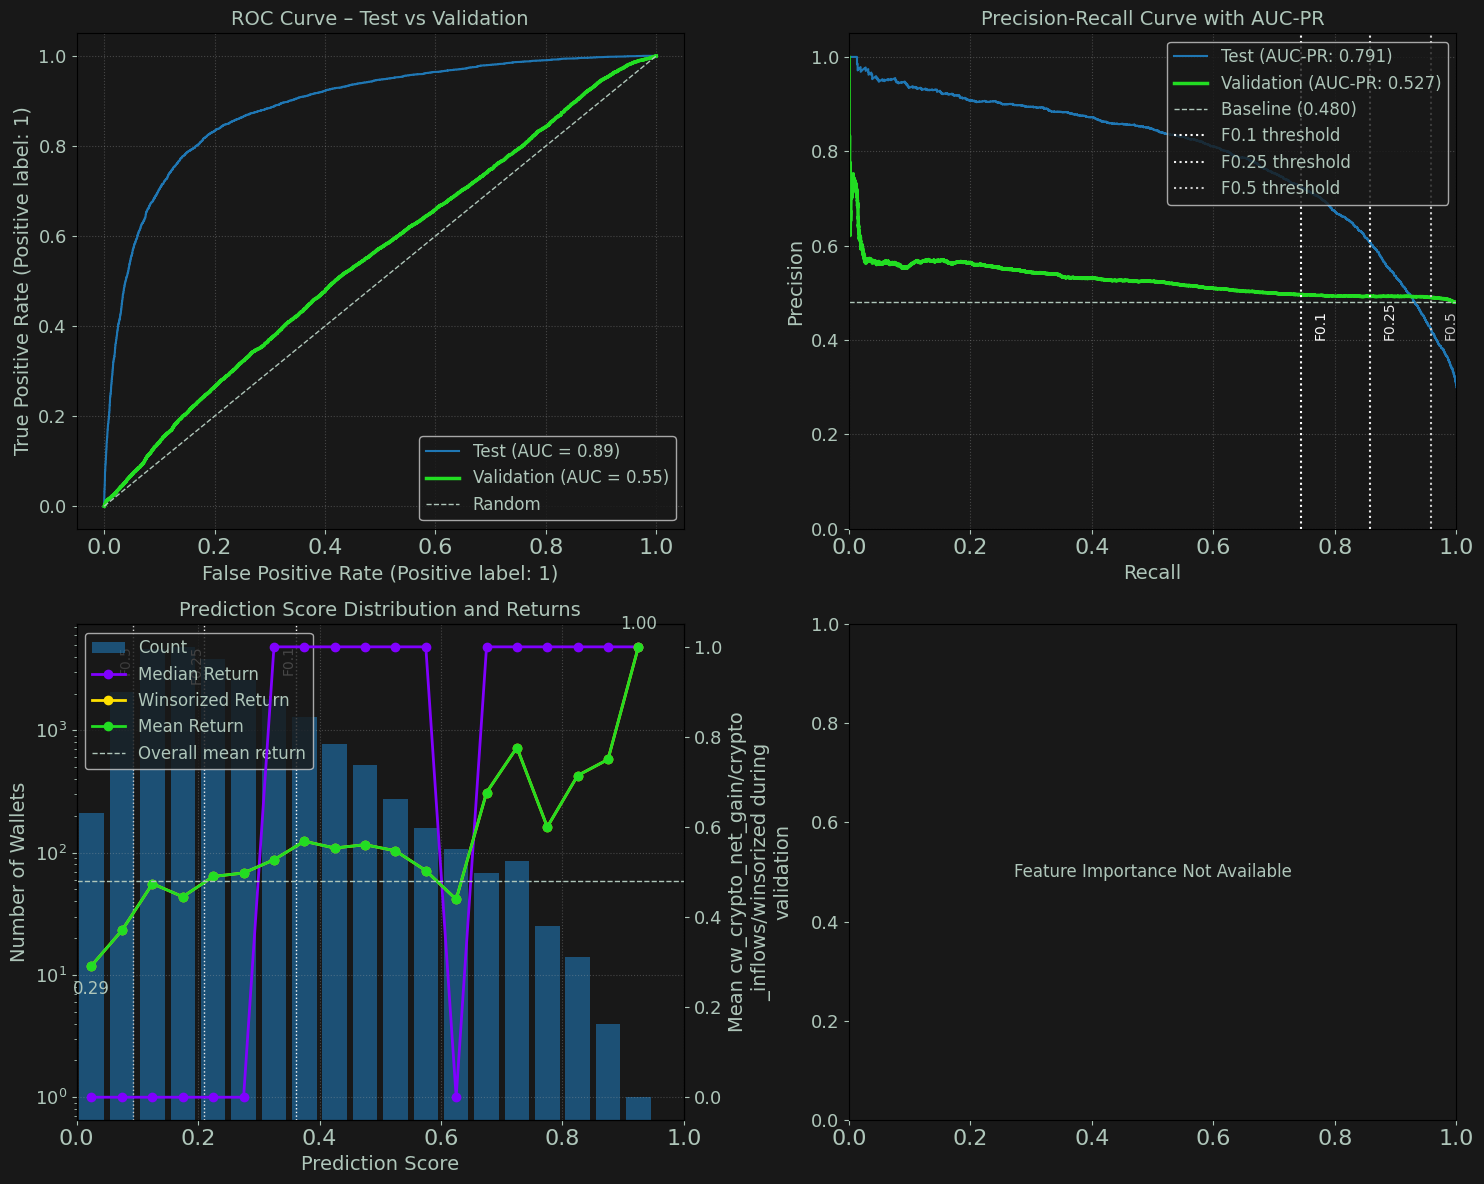

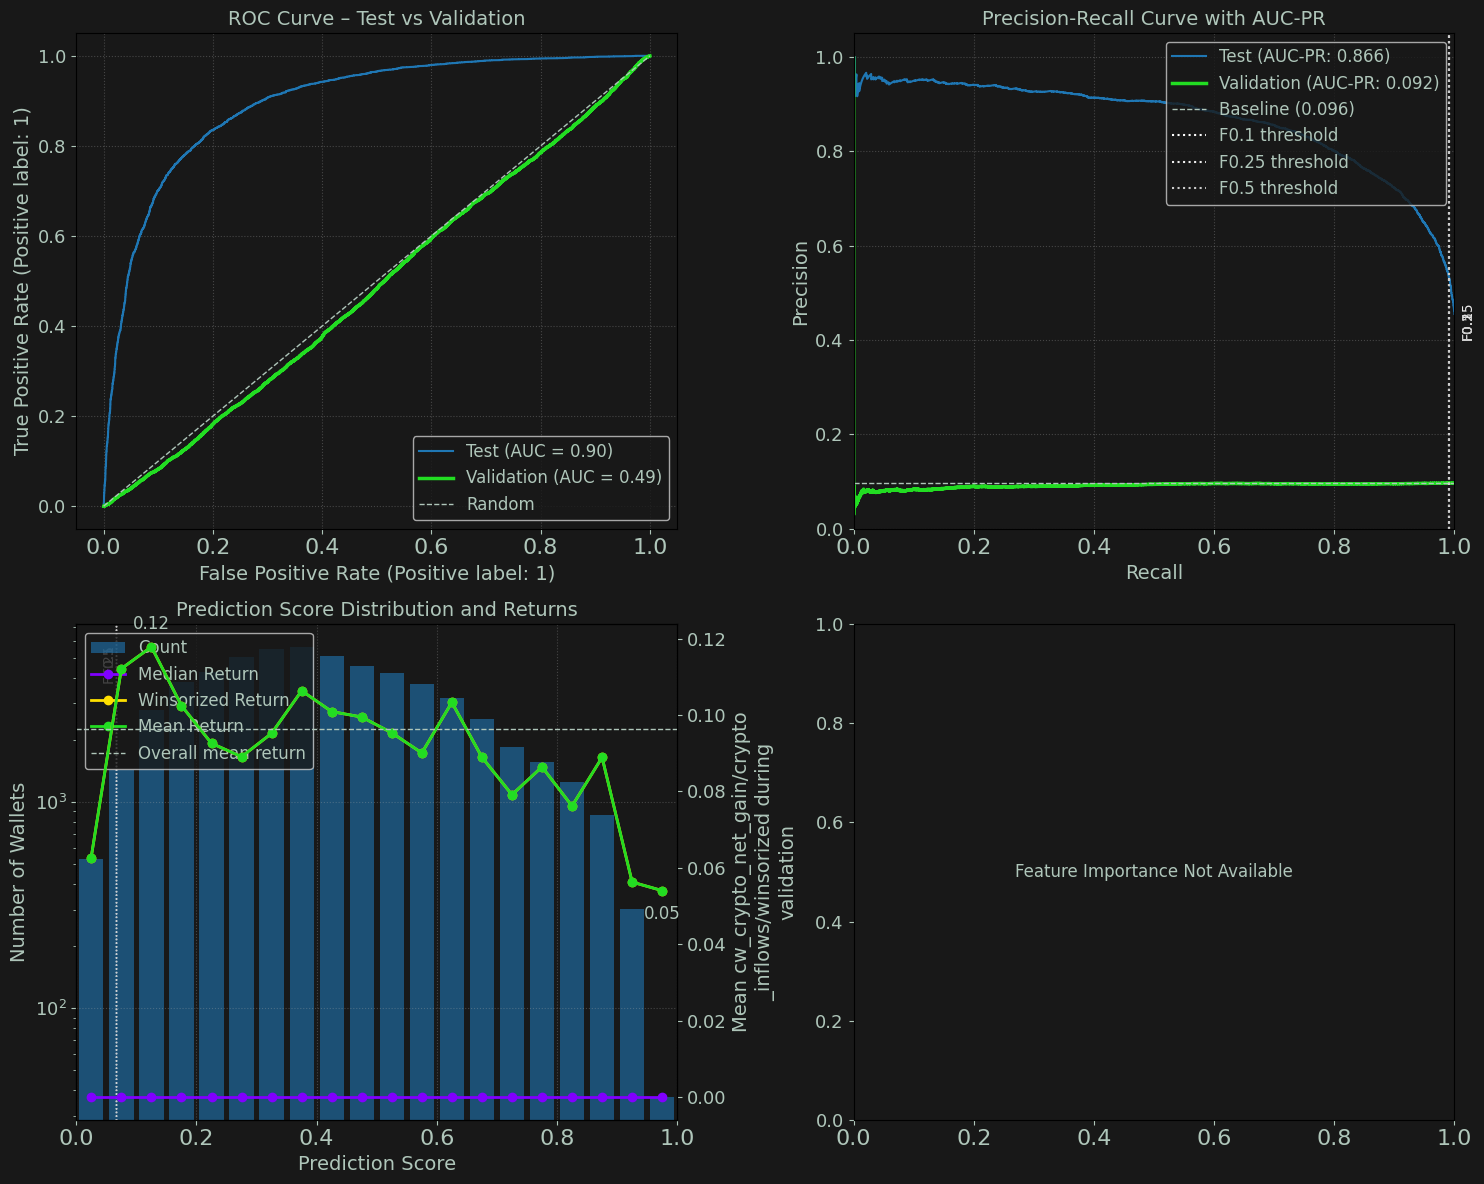

In [16]:
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()

## Single Model Sequence

### Train Single Model

#### retrieve file uris

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)

# Generate URIs for specific dates without any prior setup
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)
s3_uris

#### train model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = date_suffixes[0]

modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)



In [ ]:
modeling_results = modeler.train_model()

### Score validation set

#### get existing model uri

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))



date_suffix = '231008'

# Generate URIs for specific dates without any prior setup
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris([date_suffix])

# Launch modeler
modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)


model_metadata = modeler.load_existing_model()

#### predict with batch transform

In [ ]:
transform_results = modeler.predict_with_batch_transform('val')

In [ ]:
transform_results = modeler.predict_with_batch_transform('test')

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable